# 5HDB Performance Evaluation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append('../src')
from vae_lightning_utils import load_vae_model
from ours_lightning_utils import load_our_model
from dataset_utils import get_dataset


# Load dataset

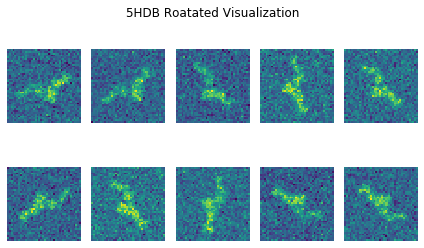

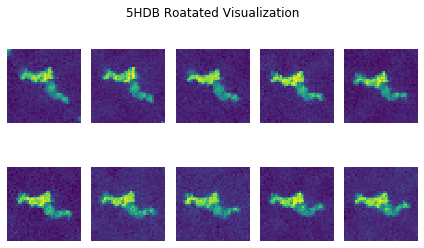

In [2]:
# Load dataset
train_loader, test_loader, image_shape = get_dataset('5hdb', 1, 0, data_base_dir='../data/')

# Visualize dataset
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.linspace(0, len(train_loader.dataset) - 1, 10).astype(int)):
    img, rot, img_rot = train_loader.dataset[i]
    ax.imshow(img.squeeze())
    ax.set_axis_off()
fig.suptitle("5HDB Roatated Visualization")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.linspace(0, len(train_loader.dataset) - 1, 10).astype(int)):
    img, rot, img_rot = train_loader.dataset[i]
    ax.imshow(img_rot.squeeze())
    ax.set_axis_off()
fig.suptitle("5HDB Roatated Visualization")
plt.tight_layout()
plt.show()

## Model predictions

In [3]:
# VAE
out_base_dir = '../output/vae_5hdb_20200619_132545'
vae_model = load_vae_model(out_base_dir, train_loader, test_loader, image_shape)
vae_model = vae_model.eval()

# Ours: DCGAN + Wasserstein
ours_base_dir = '../output/ours_5hdb_20200626_150655'
our_model = load_our_model(ours_base_dir, train_loader, test_loader, image_shape)
our_model = our_model.eval()

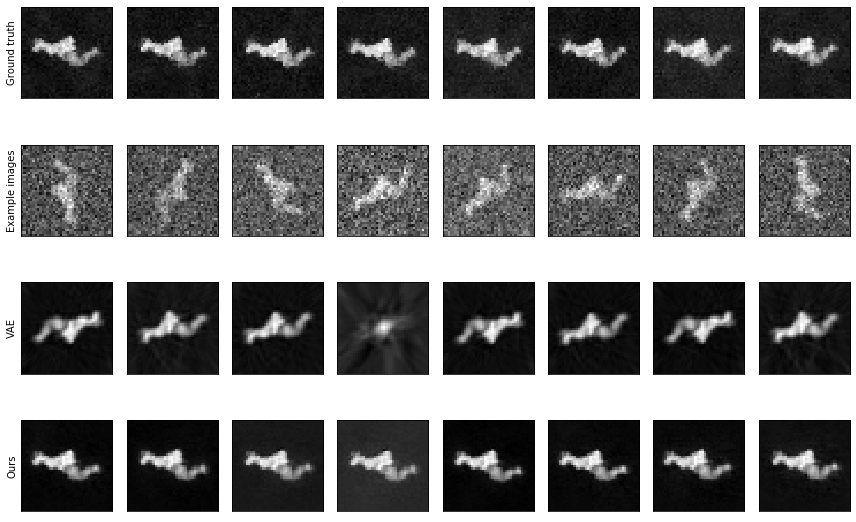

In [106]:
viz_num = 8

viz_idxs = np.linspace(0, len(test_loader.dataset) - 1, viz_num).astype(int)

w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(4, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')

for i, idx in enumerate(viz_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    ax = axs[0, i]
    ax.imshow(imgs_rot0.squeeze(), cmap='gray')
    ax = axs[1, i]
    ax.imshow(imgs.squeeze(), cmap='gray')

    # Inference vae
    imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
    ax = axs[2, i]
    ax.imshow(imgs_vae.squeeze(), cmap='gray')

    # Inference ours
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    ax = axs[3, i]
    ax.imshow(gen_imgs.squeeze(), cmap='gray')

[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]

axs[0, 0].set_ylabel('Ground truth')
axs[1, 0].set_ylabel('Example images')
axs[2, 0].set_ylabel('VAE')
axs[3, 0].set_ylabel('Ours')

plt.tight_layout()
plt.show()


## 1. Calculate average MSE 

worst average MSE value vae:  [2.40945374]
worst average MSE value our:  [0.26680595]
worst average MSE value our:  [0.30246513]
worst average MSE value our:  [0.32709747]
worst average MSE value our:  [0.41032898]
worst average MSE value vae:  [2.45001419]
worst average MSE value vae:  [2.4935582]
worst average MSE value vae:  [2.58970276]
worst average MSE value our:  [0.60025734]
worst average MSE value vae:  [3.14279388]
worst average MSE value vae:  [3.29889709]
worst average MSE value our:  [0.6093399]
worst average MSE value our:  [0.60962097]
worst average MSE value our:  [0.72217087]
worst average MSE value our:  [0.76550316]
worst average MSE value our:  [0.81420792]


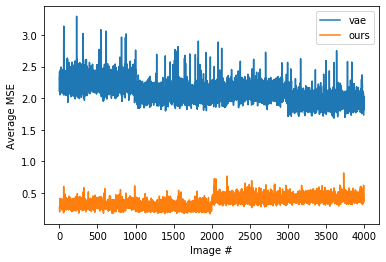

In [111]:
eval_num = len(test_loader.dataset)

eval_idxs = np.linspace(0, len(test_loader.dataset) - 1, eval_num).astype(int)

mse_vae = np.zeros([eval_num,1])
mse_ours = np.zeros([eval_num,1])
worst_mse_vae, worst_mse_ours = 0, 0
for i, idx in enumerate(eval_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    
    # Inference vae
    imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
    mse_vae[i] = np.sum( np.power(imgs_vae - imgs_rot0.detach().numpy(),2))/ 1600 
    if mse_vae[i] > worst_mse_vae:
        worst_mse_vae = mse_vae[i]
        worst_img_vae_origin = imgs_rot0.detach().numpy()
        worst_img_vae_rot = imgs.detach().numpy()
        worst_img_vae = imgs_vae
        print('worst average MSE value vae: ', str(mse_vae[i]))
    
    # Inference ours
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    mse_ours[i] = np.sum( np.power(gen_imgs - imgs_rot0.detach().numpy(),2))/ 1600 
    if mse_ours[i] > worst_mse_ours:
        worst_mse_ours = mse_ours[i]
        worst_img_ours_origin = imgs_rot0.detach().numpy()
        worst_img_ours_rot = imgs.detach().numpy()
        worst_img_ours = gen_imgs
        print('worst average MSE value our: ', str(mse_ours[i]))
    
fig1, ax1 = plt.subplots()
ax1.plot(mse_vae, label='vae')
ax1.plot(mse_ours, label='ours')
ax1.set_xlabel('Image #')
ax1.set_ylabel('Average MSE')
ax1.legend()

# Statistics
# print( 'mean MSE vae: ', np.mean(mse_vae), 'std: ', np.std(mse_vae))
# print( 'mean MSE ours:', np.mean(mse_ours), 'std:', np.std(mse_ours))

## 2. Worst-case image

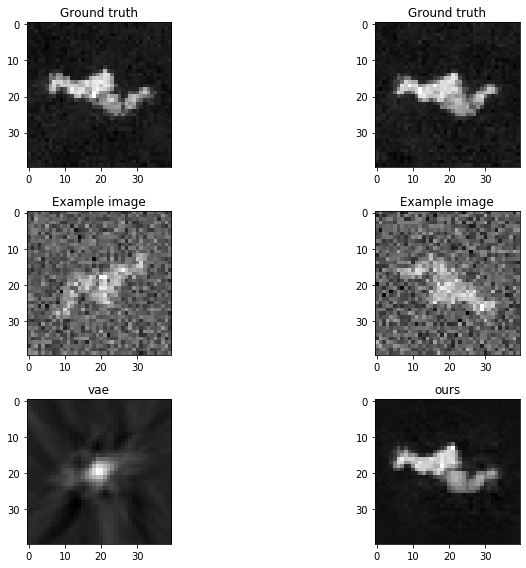

In [109]:
w, h = plt.rcParams.get('figure.figsize')
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(w * 2, h * 2), facecolor='w')
# fig.suptitle('Worst-case image')

ax1.imshow(worst_img_vae_origin.squeeze(), cmap='gray')
ax1.set_title('Ground truth')

ax3.imshow(worst_img_vae_rot.squeeze(), cmap='gray')
ax3.set_title('Example image')

ax5.imshow(worst_img_vae.squeeze(), cmap='gray')
ax5.set_title('vae')

ax2.imshow(worst_img_ours_origin.squeeze(), cmap='gray')
ax2.set_title('Ground truth')

ax4.imshow(worst_img_ours_rot.squeeze(), cmap='gray')
ax4.set_title('Example image')

ax6.imshow(worst_img_ours.squeeze(), cmap='gray')
ax6.set_title('ours')

plt.tight_layout()

## 3.SNR that 'breaks' model

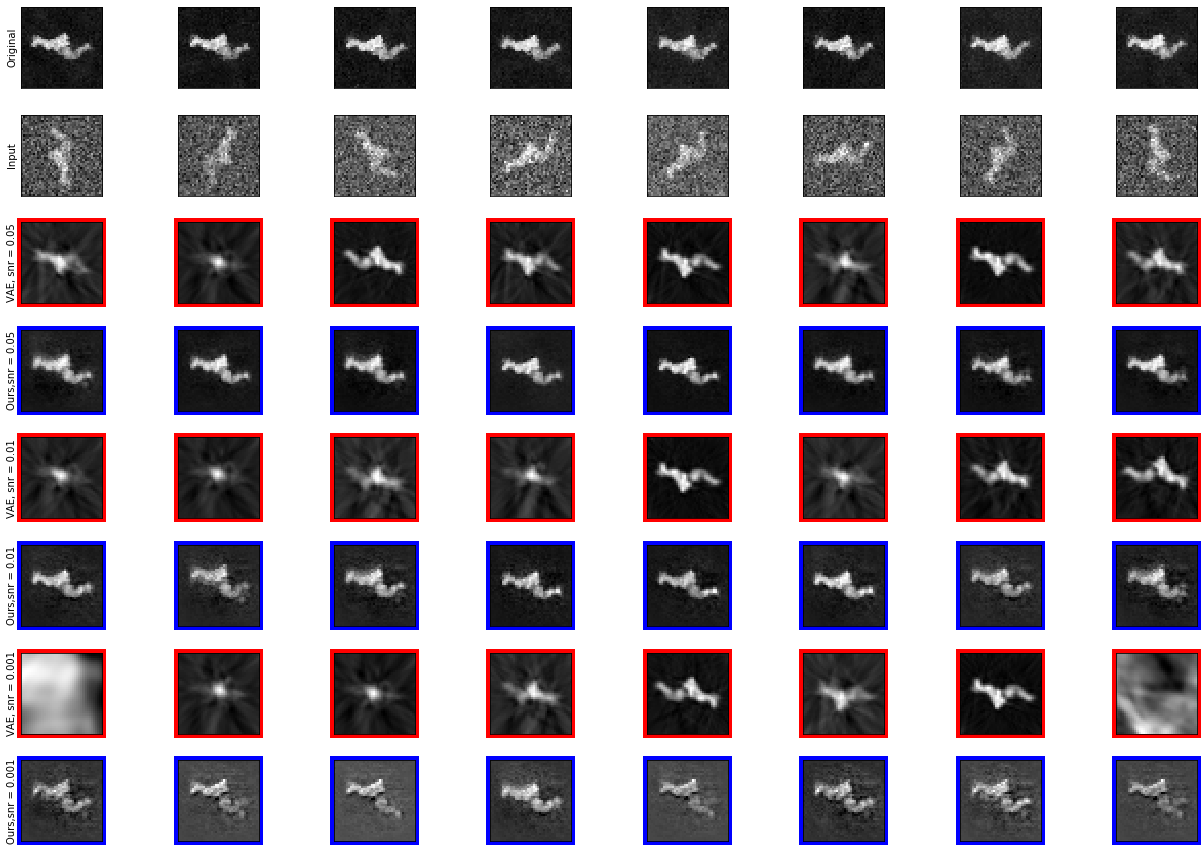

In [105]:
torch.manual_seed(0)
eval_num = 8

eval_idxs = np.linspace(0, len(test_loader.dataset) - 1, eval_num).astype(int)

w, h = plt.rcParams.get('figure.figsize')

snr_vals = [0.05, 0.01, 0.001]
fig, axs = plt.subplots(2*(len(snr_vals)+1), len(eval_idxs), figsize=(w * 3, h * 3), facecolor='w')

# Visualize input image
for i, idx in enumerate(eval_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    ax = axs[0, i]
    ax.imshow(imgs_rot0.squeeze(), cmap='gray')

    ax = axs[1, i]
    ax.imshow(imgs.squeeze(), cmap='gray')

axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Input')

for j, snr in enumerate(snr_vals):
    for i, idx in enumerate(eval_idxs):
        # Get input and add noise
        imgs, rot, imgs_rot0 = test_loader.dataset[idx]
        noise_var = 1/snr
        imgs = imgs + (noise_var**0.5)*torch.randn(1,40,40)

        # Inference vae
        imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
        ax = axs[2*(j+1), i]
        ax.imshow(np.flip(imgs_vae.squeeze(), axis=1), cmap='gray')
        ax.patch.set_edgecolor('red')  
        ax.patch.set_linewidth('8') 

        # Inference ours
        z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
        gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
        gen_imgs = gen_imgs.detach().numpy()
        ax = axs[2*(j+1)+1, i]
        ax.imshow(gen_imgs.squeeze(), cmap='gray')
        ax.patch.set_edgecolor('blue')  
        ax.patch.set_linewidth('8') 

   
    
[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]

for j, snr in enumerate(snr_vals):
    axs[2*(j+1), 0].set_ylabel('VAE,' + ' snr = ' + str(snr))
    axs[2*(j+1)+1, 0].set_ylabel('Ours,' + 'snr = ' + str(snr))
    #axs[2*(j+1), int(np.floor(eval_num/2-1))].set_title('snr = ' + str(snr) + ', noise variance = ' + str(1/snr), fontsize=16)

plt.tight_layout()
plt.show()
